# Figures for Mapping GHG emissions paper

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#A055E6', '#6EE588','#498DE6', '#E6A730', '#E66070']#.reverse()

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [2]:
# Load data
data_path = "../data/"
data = pd.read_parquet(data_path+'input_data/country_summaries_w_uncertainties_unpivoted.parquet')

## Figure 1 - Variation across 6 dimensions

In [3]:
filter_df(data_filt[data_filt['Product group']=='N-fertilisers'], ['Gas', 'Year'], [['CO$_{2e}$ - 100yr'], [2020]])

NameError: name 'data_filt' is not defined

In [3]:
## Format data input
year = 2020
gas = 'CO$_{2e}$ - 100yr'

data_filt = data[[i in ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'] for i in data['Type']]]

data_filt['Gas type'] = ['Total' if i in ['CO2e_100a', 'CO2e_20a'] else 'Gas' for i in data_filt['Gas']]
data_filt['Gas'] = data_filt['Gas'].replace({'CO2e_100a':'CO$_{2e}$ - 100yr', 'CO2e_20a':'CO$_{2e}$ - 20yr'})

data_filt = data_filt[data_filt['Type'] != data_filt['Product group']]

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

data_filt_ds = filter_df(data_filt, ['Product type'], ['Downstream'])
data_world = data_filt_ds[data_filt_ds['Region']=='World']
data_regional = data_filt_ds[data_filt_ds['Region']!='World']

C:\Users\lukec\AppData\Local\Temp/ipykernel_1324/365750854.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filt['Gas type'] = ['Total' if i in ['CO2e_100a', 'CO2e_20a'] else 'Gas' for i in data_filt['Gas']]
C:\Users\lukec\AppData\Local\Temp/ipykernel_1324/365750854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filt['Gas'] = data_filt['Gas'].replace({'CO2e_100a':'CO$_{2e}$ - 100yr', 'CO2e_20a':'CO$_{2e}$ - 20yr'})


In [4]:
all_rms = filter_df(data_filt, ['Region', 'Gas', 'Type'], [['World'], ['CO$_{2e}$ - 100yr'], ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']])

In [30]:
ints = filter_df(data_filt, ['Region', 'Gas', 'Year', 'Product type', 'Type'], [['World'], ['CO$_{2e}$ - 100yr'], [year], ['Intermediates'], ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']])
temp = ints.groupby(['Product group', 'Type']).sum().reset_index().merge(ints.groupby(['Product group']).sum().reset_index(), on='Product group')
temp['ratio'] = temp['y_x']/temp['y_y']
int_type_ratios = temp[['Product group', 'Type', 'ratio']]

source_df = filter_df(data_world, ['Year', 'Gas'], [[year], [gas]])
source_2020 = int_type_ratios.merge(source_df.groupby('Type').sum().reset_index(), left_on='Product group', right_on='Type', how='outer')
source_2020['final'] = source_2020['ratio']*source_2020['y']
source_2020['final_sigma'] = source_2020['ratio']*source_2020['sigma_y']
source_2020['y'] = list(source_2020['final'][:-4])+list(source_2020['y'][-4:])
source_2020['sigma_y'] = list(source_2020['final_sigma'][:-4])+list(source_2020['sigma_y'][-4:])
source_2020['Type'] = list(source_2020['Type_x'][:-4])+list(source_2020['Type_y'][-4:])

In [31]:
ints = filter_df(data_filt, ['Region', 'Gas', 'Product type', 'Type'], [['World'], ['CO$_{2e}$ - 100yr'], ['Intermediates'], ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']])
temp = ints.groupby(['Year', 'Product group', 'Type']).sum().reset_index().merge(ints.groupby(['Year', 'Product group']).sum().reset_index(), on=['Year', 'Product group'])
temp['ratio'] = temp['y_x']/temp['y_y']
int_type_ratios = temp[['Year', 'Product group', 'Type', 'ratio']]

source_df = filter_df(data_world, ['Gas'], [[gas]])
source = int_type_ratios.merge(source_df.groupby(['Year', 'Type']).sum().reset_index(), left_on=['Year', 'Product group'], right_on=['Year', 'Type'], how='outer')
source['final'] = source['ratio']*source['y']
source['final_sigma'] = source['ratio']*source['sigma_y']
source['final'] = [i if str(i) != 'nan' else source['y'].iloc[num] for num, i in enumerate(source['final'])]
source['final_sigma'] = [i if str(i) != 'nan' else source['sigma_y'].iloc[num] for num, i in enumerate(source['final_sigma'])]
source['Type'] = [i if str(i) != 'nan' else source['Type_y'].iloc[num] for num, i in enumerate(source['Type_x'])]

In [32]:
# IEA direct emissions
# 2020 1.360173e+06 / 1.017035e+05
# 2030 1.723519e+06 / 1.268001e+05
# 2050 2.180567e+06 / 1.823858e+05

In [5]:
sns.set_style('ticks')

def plot_defaults(data, dim, ax, fontsize = 14, hue=False, title=None, alpha=1, horiz=True, scale_factor=1E3, colors=None):
    if hue is False:
        hue = dim[1] if type(dim) is list else None
    x = dim[0] if type(dim) is list else dim
    sorter = 'Year' if 'Year' in dim else 'y'
    sorter = [dim[-1], 'y'] if type(dim) is list else sorter
    data_used = data.groupby(dim).sum().reset_index().sort_values(sorter)

    data_used['y'], data_used['sigma_y'] = data_used['y']/scale_factor, data_used['sigma_y']/scale_factor

    if horiz:
        sns.barplot(data=data_used, x='y', y=x, hue=hue, ax=ax, xerr = data_used['sigma_y'], errwidth=10, alpha=alpha, palette=colors)
        ax.set_ylabel(None)
        ax.set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize+2)
        ax.grid(axis='x')
    else:
        sns.barplot(data=data_used, x=x, y='y', hue=hue, ax=ax, yerr = data_used['sigma_y'], errwidth=10, alpha=alpha, palette=colors)
        ax.set_xlabel(None)
        ax.set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize+2)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    if title is None:
        title = dim[0] if type(dim) is list else dim
    ax.set_title(title, fontsize=fontsize+4)
    return ax

C:\Users\lukec\AppData\Local\Temp/ipykernel_1324/987128820.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_uncaps['Type'] = source_uncaps['Type'].replace({'Direct Process':'Direct process', 'Indirect Energy Use':'Indirect energy use', 'Direct Energy Use':'Direct energy use'})


NameError: name 'gas_summ' is not defined

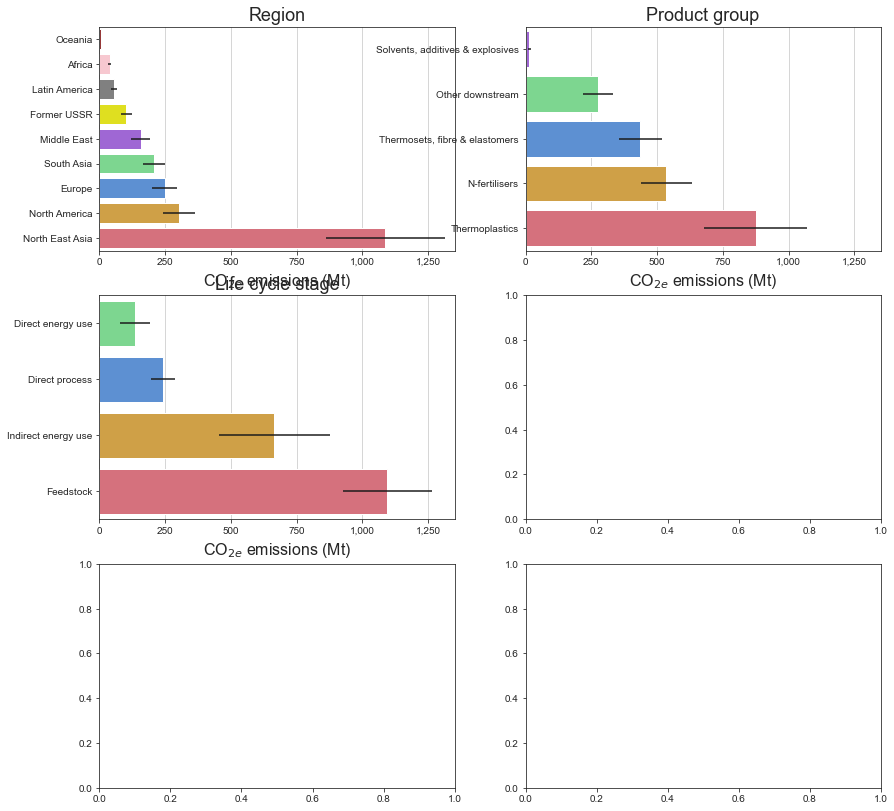

In [6]:
fig, axs = plt.subplots(3,2, figsize=[14,14], facecolor='white')
fontsize = 14

plt.rcParams['font.size'] = 12
sns.set(font_scale=1.5)
sns.set_style('ticks')

axs[0,0] = plot_defaults(filter_df(data_regional, ['Year', 'Gas'], [[year], [gas]]),
                         'Region', axs[0,0], colors=['brown', 'pink', 'grey', 'yellow']+colors)
axs[0,0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[0,0].set_xlim([0, 1350])
axs[0,0].set_xticks([0,250,500,750,1000,1250])

axs[0,1] = plot_defaults(filter_df(data_world, ['Year', 'Gas'], [[year], [gas]]),
                         'Product group', axs[0,1], colors=colors)
axs[0,1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[0,1].set_xlim([0, 1350])
axs[0,1].set_xticks([0,250,500,750,1000,1250])

source_uncaps = all_rms[all_rms['Year']==year]
source_uncaps['Type'] = source_uncaps['Type'].replace({'Direct Process':'Direct process', 'Indirect Energy Use':'Indirect energy use', 'Direct Energy Use':'Direct energy use'})
axs[1,0] = plot_defaults(source_uncaps, 'Type', axs[1,0], title='Emissions source', colors=colors[1:])
axs[1,0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
axs[1,0].set_xlim([0, 1350])
axs[1,0].set_xticks([0,250,500,750,1000,1250])
axs[1,0].set_title('Life cycle stage')

sns.barplot(data=gas_summ, x='y', y='Gas', hue='Time horizon', ax=axs[1,1], xerr = [gas_summ_20['sigma_y'], gas_summ_100['sigma_y']], errwidth=10, alpha=1, palette=colors[1:])
axs[1,1].set_ylabel(None)
axs[1,1].set_xlabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize+2)
axs[1,1].grid(axis='x')
axs[1,1].set_xlim([-1E2, 2100])
axs[1,1].legend(loc='upper right', title='Time horizon')
axs[1,1].set_title('GHG type', fontsize=fontsize+4)
axs[1,1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

gs = axs[2, 0].get_gridspec()
for ax in axs[2,:]:
    ax.remove()
axs[2, 0] = fig.add_subplot(gs[2, :])

df1 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(1978,2021))]).groupby('Year').sum().reset_index()
#df2 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(2021,2051))]).groupby('Year').sum().reset_index()
axs[2,0].bar(df1['Year'], df1['y']/1E3, color=colors[3], label='Indirect energy use')
#axs[2,0].bar(df2['Year'], df2['y']/1E3, color=colors[3], label='Total forecast')

df3 = filter_df(all_rms[all_rms['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(1978,2021))]).groupby('Year').sum().reset_index()
#df4 = filter_df(source[source['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(2021,2051))]).groupby('Year').sum().reset_index()
#axs[2,0].bar(df3['Year'], df3['final']/1E3, color='pink', label="Other life cycle stages")
axs[2,0].bar(df3['Year'], df3['y']/1E3, color='pink', label="Other life cycle stages")

iea_x = [2000, 2005, 2010, 2015, 2020]#, 2021]
iea_y = np.array((0.91, 1.04,1.19, 1.32, 1.30))*1E3 #1.37
# iea_fx = [2021, 2030, 2050]
# iea_fy = np.array((1.30*1.2, 1.30*1.3))*1E3

axs[2,0].scatter(iea_x, iea_y,  color='purple',edgecolor='k', label='IEA estimate')
#axs[2,0].scatter(iea_fx, iea_fy, color=colors[4], edgecolor='k', label='IEA forecast')

axs[2,0].set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize+2)
axs[2,0].set_xlim(1978,2021)
axs[2,0].grid(axis='y')
handles, labels = axs[2,0].get_legend_handles_labels()
axs[2,0].legend(handles=[handles[1], handles[2], handles[0]], labels = [labels[1], labels[2], labels[0]], loc='upper left')
axs[2,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

axs[2,0].errorbar(df1['Year'], df1['y']/1E3, df1['sigma_y']/1E3, linestyle='None', color='black', capsize=0)
#axs[2,0].errorbar(df2['Year'], df2['y']/1E3, df2['sigma_y']/1E3, linestyle='None', color='black', capsize=0)
axs[2,0].set_title('Year')

fs = 18
h = 1.1
w = 0
axs[0,0].text(w, h, 'a', transform = axs[0,0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[0,1].text(w, h, 'b', transform = axs[0,1].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1,0].text(w, h, 'c', transform = axs[1,0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[1,1].text(w, h, 'd', transform = axs[1,1].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
axs[2,0].text(w-0.07, h, 'e', transform = axs[2,0].transAxes, fontsize=fs, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

#fig.suptitle('Variation across 6 dimensions', fontsize=28)
fig.tight_layout()

In [10]:
# Save figure
fig.savefig(data_path+'analysis_outputs/6_dimensions_historical.png', bbox_inches='tight', dpi=150)

In [8]:
data_path = "../data/"
impactMethods_20 = data_path+ "extra_inputs/EI_3_8_IPCC2013_GWP20a.xml"
impactMethods_100 = data_path+ "extra_inputs/EI_3_8_IPCC2013_GWP100a.xml"

import xml.etree.ElementTree as ET
pd.options.mode.chained_assignment = None

# CO2e conversion of gases
# Define functions
def to_listlist(inlist: list):
    """Ensures element is a list of lists even if single inner list"""
    return [inlist] if type(inlist[0]) is not list else inlist

def read_xml_attributes(filepath:str,branches:list,attributes:list,df=False):
    """This function creates a dataframe of attributes within an xml file.\n
    Inputs:\n
    filepath - path to xml file\n
    branches - list of successive branch choices\n
    attributes - attributes to be read from chosen branch\n
    Outputs:\n
    df - pandas dataframe of attributes for each end branch\n
    Requirements: pandas as pd, xml.etree.ElementTree as ET"""
    if df is False: df = pd.DataFrame([],columns=[i for sublist in to_listlist(attributes) for i in sublist])
    tree_loc = ET.parse(filepath). getroot()
    branches, attributes = to_listlist(branches), to_listlist(attributes)
    attr_values = dict()
    for pathnum, path in enumerate(branches):
        for branch in path:
            for num,val in enumerate([branch in i.tag for i in tree_loc]):
                if val:
                    if branch is path[-1]:
                        attr_values.update(dict(zip(attributes[pathnum],[tree_loc[num].attrib[i] if i else tree_loc[num].text for i in attributes[pathnum]])))
                        if path is branches[-1]:
                            df = pd.concat([df, pd.DataFrame(np.array([[i] for i in attr_values.values()]).transpose(),columns=attr_values.keys())],ignore_index=True)
                    else:
                        tree_loc=tree_loc[num]
                        break
    return df

impacts_20, impacts_100 = [read_xml_attributes(input_file,['dataset','flowData','exchange'],['name','category','subCategory','meanValue']).rename(columns={'meanValue':name}) for input_file, name in zip([impactMethods_20, impactMethods_100], ['CO2e_20a', 'CO2e_100a'])]
impacts = impacts_20.merge(impacts_100, on=['name', 'category', 'subCategory'], how='outer')

impacts = impacts.groupby('name').first().reset_index()

In [9]:
ipcc_gas_names = {'Carbon dioxide':'Carbon dioxide, fossil',
 'Carbon monoxide':'Carbon monoxide, fossil',
 'Ethane':'Ethane, 1,1-difluoro-, HFC-152a',
 'Methane':'Methane, fossil',
 'Other':'Carbon dioxide, fossil'}

scale_factor = 1E3

## Add in direct process emissions unaccounted for by EcoInvent values
# excess_int_gas = filter_df(data_filt[[i not in ['Perfluoropentane', 'Nitrogen fluoride', 'Carbon dioxide', 'CO$_{2e}$ - 20yr', 'CO$_{2e}$ - 100yr'] for i in data_filt['Gas']]], ['Region', 'Year', 'Product type', 'Type'], [['World'], [year], ['Intermediates'], ['Direct Process']]).groupby('Gas').sum().drop(columns=['Year']).reset_index()

gas_summ = filter_df(data_world[[i not in ['Perfluoropentane', 'Nitrogen fluoride'] for i in data_world['Gas']]], ['Year'], [[year]]).groupby('Gas').sum().drop(columns=['Year']).reset_index()

# Correct error made in processing
gas_summ['Gas'] = gas_summ['Gas'].replace({'Dinitrogen monoxide':'Nitric oxide', 'Nitric oxide':'Dinitrogen monoxide'})

gas_summ = gas_summ.merge(impacts, left_on=gas_summ['Gas'].replace(ipcc_gas_names), right_on='name', how='left')
gas_summ_20 = gas_summ.dropna()
gas_summ_20['y'] = gas_summ_20['y']*gas_summ_20['CO2e_20a'].astype(float)/scale_factor
gas_summ_20['sigma_y'] = gas_summ_20['sigma_y']*gas_summ_20['CO2e_20a'].astype(float)/scale_factor
gas_summ_20['Time horizon'] = '20-year'
gas_summ_20 = gas_summ_20.sort_values('y')
gas_summ_100 = gas_summ.dropna()
gas_summ_100['y'] = gas_summ_100['y']*gas_summ_100['CO2e_100a'].astype(float)/scale_factor
gas_summ_100['sigma_y'] = gas_summ_100['sigma_y']*gas_summ_100['CO2e_100a'].astype(float)/scale_factor
gas_summ_100['Time horizon'] = '100-year'
gas_summ_100 = gas_summ_100.sort_values('y')
gas_summ = pd.concat((gas_summ_20, gas_summ_100))

Text(0.5, 1.0, 'Total expected future emissions')

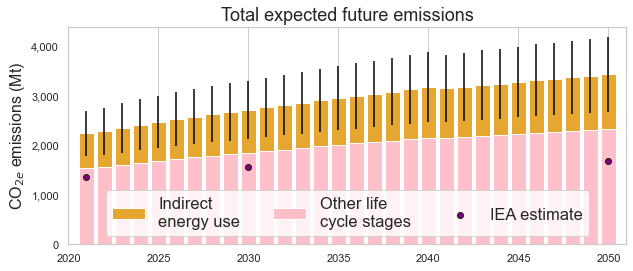

In [26]:

fig, ax = plt.subplots(1,1, figsize=[10,4])


#df3 = filter_df(source[source['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(1978,2021))]).groupby('Year').sum().reset_index()
df4 = filter_df(all_rms[all_rms['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(2021,2051))]).groupby('Year').sum().reset_index()
# ax.bar(df3['Year'], df3['final']/1E3, color='pink', label="'Direct' emissions (IEA definition)")
ax.bar(df4['Year'], df4['y']/1E3, color='pink', label="Other life\ncycle stages", zorder=2)

# df1 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(1978,2021))]).groupby('Year').sum().reset_index()
df2 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(2021,2051))]).groupby('Year').sum().reset_index()
df2.loc[29, 'sigma_y'] = df2.loc[28, 'sigma_y']+(df2.loc[28, 'sigma_y']-df2.loc[27, 'sigma_y'])
# ax.bar(df1['Year'], df1['y']/1E3, color=colors[3], label='Indirect Energy Use')
ax.bar(df2['Year'], df2['y']/1E3, color=colors[3], label='Indirect\nenergy use', zorder=1)

# iea_x = [2000, 2005, 2010, 2015, 2020]#, 2021]
# iea_y = np.array((0.91, 1.04,1.19, 1.32, 1.30))*1E3 #1.37
iea_fx = [2021, 2030, 2050]
iea_fy = np.array((1.37, 1.30*1.2, 1.30*1.3))*1E3

#ax.scatter(iea_x, iea_y,  color='pink',edgecolor='k', label='IEA estimate')
ax.scatter(iea_fx, iea_fy, color='purple',edgecolor='k', label='IEA estimate', zorder=3)

ax.set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize+2)
ax.set_xlim(2020, 2051)
ax.grid(axis='y')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[2], handles[1], handles[0]], labels = [labels[2], labels[1], labels[0]], loc='lower center', ncol=3)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#ax.errorbar(df1['Year'], df1['y']/1E3, df1['sigma_y']/1E3, linestyle='None', color='black', capsize=0)
ax.errorbar(df2['Year'], df2['y']/1E3, df2['sigma_y']/1E3, linestyle='None', color='black', capsize=0)
ax.set_title('Total expected future emissions')

In [12]:
# Save figure
fig.savefig('../data/analysis_outputs/6_dimensions_forecast.png', bbox_inches='tight', dpi=150)

In [12]:
df2

,Year,y,sigma_y
0,2021,2.240840e+06,464702.149558
1,2022,2.284996e+06,477183.139509
2,2023,2.352665e+06,499233.304332
3,2024,2.415625e+06,516314.743794
4,2025,2.474995e+06,529578.015132
5,2026,2.533982e+06,543986.846605
6,2027,2.582141e+06,554860.989715
7,2028,2.628328e+06,564075.765904
8,2029,2.674448e+06,577287.613220
9,2030,2.722847e+06,589343.490916


<ErrorbarContainer object of 3 artists>

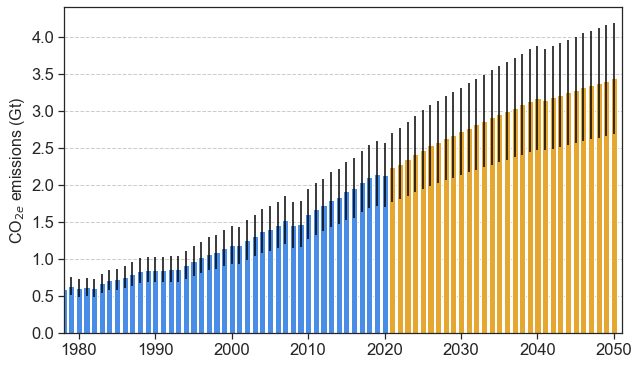

In [35]:

fig, ax = plt.subplots(1,1, figsize=[10,6])

plt.rcParams['font.size'] = 12
sns.set(font_scale=1.5)
sns.set_style('ticks')

# df3 = filter_df(all_rms[all_rms['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(1978,2021))]).groupby('Year').sum().reset_index()
# df4 = filter_df(all_rms[all_rms['Type'] != 'Indirect Energy Use'], ['Year'], [list(range(2021,2051))]).groupby('Year').sum().reset_index()
# # ax.bar(df3['Year'], df3['final']/1E3, color='pink', label="'Direct' emissions (IEA definition)")
# ax.bar(df4['Year'], df4['y']/1E3, color='pink', label="Other life\ncycle stages", zorder=2)

# df1 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(1978,2021))]).groupby('Year').sum().reset_index()
loc_2050 = 72
df2 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(1978,2051))]).groupby('Year').sum().reset_index()
df2.loc[loc_2050, 'sigma_y'] = df2.loc[loc_2050-1, 'sigma_y']+(df2.loc[loc_2050-1, 'sigma_y']-df2.loc[loc_2050-2, 'sigma_y'])
# ax.bar(df1['Year'], df1['y']/1E3, color=colors[3], label='Indirect Energy Use')
split_val = 43
ax.bar(df2['Year'][:split_val], df2['y'][:split_val]/1E6, color=colors[2], label='Indirect\nenergy use', zorder=1)
ax.bar(df2['Year'][split_val:], df2['y'][split_val:]/1E6, color=colors[3], label='Indirect\nenergy use', zorder=1)
# df2 = filter_df(data_world, ['Gas', 'Year'], [[gas], list(range(1978,2051))]).groupby('Year').sum().reset_index()
# df2.loc[loc_2050, 'sigma_y'] = df2.loc[loc_2050-1, 'sigma_y']+(df2.loc[loc_2050-1, 'sigma_y']-df2.loc[loc_2050-2, 'sigma_y'])
# # ax.bar(df1['Year'], df1['y']/1E3, color=colors[3], label='Indirect Energy Use')
#
# ax.bar(df2['Year'][:40], df2['y'][:40]/1E3, color=colors[3], label='Indirect\nenergy use', zorder=1)

# iea_x = [2000, 2005, 2010, 2015, 2020]#, 2021]
# iea_y = np.array((0.91, 1.04,1.19, 1.32, 1.30))*1E3 #1.37
# iea_fx = [2021, 2030, 2050]
# iea_fy = np.array((1.37, 1.30*1.2, 1.30*1.3))*1E3

#ax.scatter(iea_x, iea_y,  color='pink',edgecolor='k', label='IEA estimate')
# ax.scatter(iea_fx, iea_fy, color='purple',edgecolor='k', label='IEA estimate', zorder=3)

ax.set_ylabel('CO$_{2e}$ emissions (Gt)', fontsize=fontsize+2)
ax.set_xlim(1978, 2051)
ax.grid(axis='y', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=[handles[2], handles[1], handles[0]], labels = [labels[2], labels[1], labels[0]], loc='lower center', ncol=3)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))

#ax.errorbar(df1['Year'], df1['y']/1E3, df1['sigma_y']/1E3, linestyle='None', color='black', capsize=0)
ax.errorbar(df2['Year'], df2['y']/1E6, df2['sigma_y']/1E6, linestyle='None', color='black', capsize=0)
#ax.set_title('Total expected future emissions')

In [36]:
fig.savefig(data_path+'analysis_outputs/presentation_global.png', dpi=300)

In [15]:
## Output to data table
df2['ValueWithUncertainty'] = [f"{row['y']/1E6:.1f}±{row['sigma_y']/1E6:.1f}" for row in df2.iloc]
df4['ValueWithUncertainty'] = [f"{row['y']/1E6:.1f}±{row['sigma_y']/1E6:.1f}" for row in df4.iloc]

df2[['Year','ValueWithUncertainty']].merge(df4[['Year','ValueWithUncertainty']], on='Year').to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/forecast_values_update.csv')

,Year,y,sigma_y,ValueWithUncertainty
0,2021,2.240840e+06,464702.149558,2.2±0.5
1,2022,2.284996e+06,477183.139509,2.3±0.5
2,2023,2.352665e+06,499233.304332,2.4±0.5
3,2024,2.415625e+06,516314.743794,2.4±0.5
4,2025,2.474995e+06,529578.015132,2.5±0.5
5,2026,2.533982e+06,543986.846605,2.5±0.5
6,2027,2.582141e+06,554860.989715,2.6±0.6
7,2028,2.628328e+06,564075.765904,2.6±0.6
8,2029,2.674448e+06,577287.613220,2.7±0.6
9,2030,2.722847e+06,589343.490916,2.7±0.6


## Figure 2 - Map evolution

In [17]:
data_path = ../data/'

production_file = data_path+'processed\icisFacilityProduction_w_uncertainties.csv'
country_groupings_file = data_path+'extra_inputs/country_regions.csv'

In [18]:
# Production
production_facils = pd.read_csv(production_file, index_col=0)
production = production_facils.groupby(['COUNTRY/TERRITORY']).sum().reset_index().drop(columns=['#', 'START_YR', 'LATITUDE', 'LONGITUDE'])

country_groupings = pd.read_csv(country_groupings_file)
production = pd.merge(production, country_groupings, on='COUNTRY/TERRITORY', how='left')

region_prod = production.groupby(['Region']).sum()

In [19]:
# Emissions

region_time = filter_df(data_regional, ['Gas'],[['CO$_{2e}$ - 100yr']]).groupby(['Region','Year']).sum().reset_index()
region_time = region_time.pivot(index='Region', columns='Year', values=['y', 'sigma_y'])
region_time[('sigma_y', 2050)] = region_time[('sigma_y', 2049)]+(region_time[('sigma_y', 2049)]-region_time[('sigma_y', 2048)])

# Emission factors
em_factors = pd.DataFrame(region_time['y'].values/region_prod[[str(col) for col in region_time['y'].columns]].values,
                          columns=[str(col) for col in region_time['y'].columns], index=region_time['y'].index)

em_errors = pd.DataFrame(region_time['sigma_y'].values/region_prod[[str(col) for col in region_time['sigma_y'].columns]].values,
                          columns=[str(col) for col in region_time['sigma_y'].columns], index=region_time['sigma_y'].index)

scale_factor = 1000
region_time['y'], region_time['sigma_y'], region_prod = region_time['y']/scale_factor, region_time['sigma_y']/scale_factor, region_prod.div(scale_factor)

C:\Users\lukec\AppData\Local\Temp/ipykernel_12012/2362404608.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


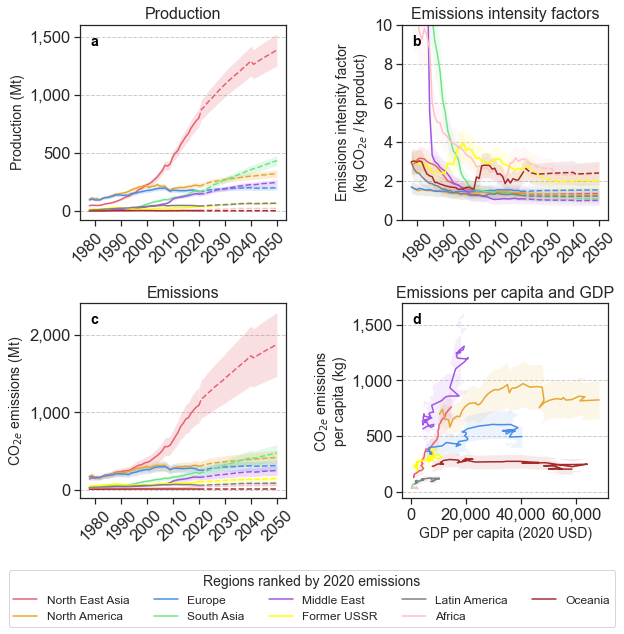

In [23]:
sns.set_style('ticks')

fig = plt.figure(figsize=[9,8], facecolor='white')
fontsize=14

# Production
ax = fig.add_subplot(2,2,1)

colors_used = colors[-1::-1]+['yellow', 'grey', 'pink', 'brown']

bf_years = [str(i) for i in range(1978,2021)]
aft_years = [str(i) for i in range(2020, 2051)]
bf_errs = [i+'_sigma' for i in bf_years]
aft_errs = [i+'_sigma' for i in aft_years]


ax2 = fig.add_subplot(2,2,3)

region_time.sort_values(('y', 2020), ascending=False, inplace=True)
for num, region in enumerate(region_time.index):
    y = region_time.loc[region].loc['y'][[int(i) for i in bf_years]].values
    err = region_time.loc[region].loc['sigma_y'][[int(i) for i in bf_years]].values
    ax2.plot(bf_years, y, color = colors_used[num], label=region)
    ax2.fill_between(bf_years, y-err, y+err, alpha=0.2, facecolor=colors_used[num])

    y = region_time.loc[region].loc['y'][[int(i) for i in aft_years]].values
    err = region_time.loc[region].loc['sigma_y'][[int(i) for i in aft_years]].values
    ax2.plot(aft_years, y, '--', color = colors_used[num])
    ax2.fill_between(aft_years, y-err, y+err, alpha=0.2, facecolor=colors_used[num])

for num, region in enumerate(region_time.index):
    y = region_prod.loc[region][bf_years].values
    err = region_prod.loc[region][bf_errs].values
    ax.plot(bf_years, y, color = colors_used[num])
    ax.fill_between(bf_years, y-err, y+err, alpha=0.2, facecolor=colors_used[num])

    y = region_prod.loc[region][aft_years].values
    err = region_prod.loc[region][aft_errs].values
    ax.plot(aft_years, y, '--', color = colors_used[num])
    ax.fill_between(aft_years, y-err, y+err, alpha=0.2, facecolor=colors_used[num])

# pl.fill_between(x, y-error, y+error,
#     alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#     linewidth=4, linestyle='dashdot', antialiased=True)

ax3 = fig.add_subplot(2,2,2)

for num, region in enumerate(region_time.index):
    y = em_factors.loc[region][bf_years].values
    err = em_errors.loc[region][bf_years].values
    ax3.plot(bf_years, y, color = colors_used[num])
    ax3.fill_between(bf_years, y-err, y+err, alpha=0.1, facecolor=colors_used[num])

    y = em_factors.loc[region][aft_years].values
    err = em_errors.loc[region][aft_years].values
    ax3.plot(aft_years, y, '--', color = colors_used[num])
    ax3.fill_between(aft_years, y-err, y+err, alpha=0.1, facecolor=colors_used[num])


ax4 = fig.add_subplot(2,2,4)

for num, region in enumerate(region_time.index):
    filtered = filter_df(gdp_plot, ['Region'], [[region]])
    ax4.plot(filtered['GDP_capita'], filtered['y'], color = colors_used[num])
    ax4.fill_between(filtered['GDP_capita'], filtered['y']-filtered['sigma_y'], filtered['y']+filtered['sigma_y'], alpha=0.1, facecolor=colors_used[num])
    #
    # y = em_factors.loc[region][aft_years].values
    # err = em_errors.loc[region][aft_years].values
    # ax3.plot(aft_years, y, '--', color = colors_used[num])
    # ax3.fill_between(aft_years, y-err, y+err, alpha=0.1, facecolor=colors_used[num])

ax.set_title('Production', fontsize=fontsize+2)
ax.set_ylabel('Production (Mt)', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_ticks(np.arange(2, 73, 10))
ax.set_xticklabels(np.arange(1980, 2051, 10), rotation=45, rotation_mode='anchor')
ax.grid(axis='y',linestyle='--', linewidth=1)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#ax2.legend(loc='upper left', fontsize=fontsize, bbox_to_anchor=[1, 1], fancybox=True)
ax2.set_title('Emissions', fontsize=fontsize+2)
ax2.set_ylabel('CO$_{2e}$ emissions (Mt)', fontsize=fontsize)
ax2.xaxis.set_ticks(np.arange(2, 73, 10))
ax2.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax2.grid(axis='y',linestyle='--', linewidth=1)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax3.set_title('Emissions intensity factors', fontsize=fontsize+2)
ax3.set_ylabel('Emissions intensity factor\n(kg CO$_{2e}$ / kg product)', fontsize=fontsize)
ax3.xaxis.set_ticks(np.arange(2, 73, 10))
ax3.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax3.grid(axis='y',linestyle='--', linewidth=1)
ax3.set_ylim([0,10])

ax4.set_title('Emissions per capita and GDP', fontsize=fontsize+2)
ax4.set_ylabel('CO$_{2e}$ emissions\nper capita (kg)', fontsize=fontsize)
ax4.set_xlabel('GDP per capita (2020 USD)', fontsize=fontsize)
#ax4.xaxis.set_ticks(np.arange(2, 73, 10))
#ax4.set_xticklabels(np.arange(1980, 2051, 10), rotation=45)#, rotation_mode='anchor')
ax4.grid(axis='y',linestyle='--', linewidth=1)
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax4.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

w = 0.05
h = 0.95
ax.text(w, h, 'a', transform = ax.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
ax3.text(w, h, 'b', transform = ax3.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
ax2.text(w, h, 'c', transform = ax2.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
ax4.text(w, h, 'd', transform = ax4.transAxes, fontsize=fontsize, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.12), title='Regions ranked by 2020 emissions', fontsize=fontsize-2, title_fontsize=fontsize)

fig.tight_layout()

In [24]:
region_time = region_time.reset_index().sort_values('Region').set_index('Region')
for year in np.arange(1980, 2051, 10):
    region_time[('y', year)] = [str(a)+'±'+str(b) for a,b in zip(region_time[('y', year)].astype(int), region_time[('sigma_y', year)].astype(int))]#[  f"{region_time[('y', year)]:.1f}±{row['sigma_y']/1E6:.1f}" for row in .iloc]
region_time[[('y', 1980), ('y', 1990), ('y', 2000), ('y', 2010), ('y', 2020), ('y', 2030), ('y', 2040), ('y', 2050)]].to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/regional_emissions_update.csv')

In [25]:
for year in np.arange(1980, 2051, 10):
    region_prod[str(year)] = [str(int(a))+'±'+str(int(b)) if a>10 else str(a)[:3]+'±'+str(b)[:3] for a,b in zip(region_prod[str(year)], region_prod[str(year)+'_sigma'])]#[  f"{region_prod[('y', year)]:.1f}±{row['sigma_y']/1E6:.1f}" for row in .iloc]
region_prod[[str(1980), str(1990), str(2000), str(2010), str(2020), str(2030), str(2040), str(2050)]].to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/regional_production_update.csv')

In [26]:
for year in np.arange(1980, 2051, 10):
    em_factors[str(year)] = [str(int(a))+'±'+str(int(b)) if a>10 else str(a)[:3]+'±'+str(b)[:3] for a,b in zip(em_factors[str(year)], em_errors[str(year)])]#[  f"{em_factors[('y', year)]:.1f}±{row['sigma_y']/1E6:.1f}" for row in .iloc]
em_factors[[str(1980), str(1990), str(2000), str(2010), str(2020), str(2030), str(2040), str(2050)]].to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/regional_EF_update.csv')

In [27]:
gdp_plot['ValueWithUncertainty'] = [f"{row['y']:.0f}±{row['sigma_y']:.0f}" for row in gdp_plot.iloc]
gdp_plot.pivot(index='Region', columns='Year')['ValueWithUncertainty'][[1980,1990,2000,2010,2020]].to_csv('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/gdp_plot_update.csv')

## Population / GDP comparison

In [21]:
import wbdata
import pandas as pd

# Define the indicators and countries
indicators = {'NY.GDP.MKTP.CD': 'GDP', 'SP.POP.TOTL': 'Population'}
countries = [country['id'] for country in wbdata.get_country(incomelevel="HIC")]

# Download the data
wb_data = wbdata.get_dataframe(indicators, convert_date=False)

# Extract GDP and Population columns
wb_data = wb_data[['GDP', 'Population']].reset_index()

# Print the data
country_conv = {'Egypt, Arab Rep.':'Egypt', 'Czechia':'Czech Republic', 'North Macedonia':'Macedonia', 'Russian Federation':'Russia', 'Bahamas, The':'Bahamas', 'Trinidad and Tobago':'Trinidad'}
wb_data['country'] = wb_data['country'].rename(country_conv).str.upper()
wb_data.rename(columns={'country':'COUNTRY/TERRITORY', 'date':'Year'}, inplace=True)

In [22]:
country_regions = pd.read_csv('C:/Users\lukec\PycharmProjects\petrochemical-data\data\extra_inputs\country_regions.csv')
gdp_data = country_regions.merge(wb_data, on='COUNTRY/TERRITORY', how='left').groupby(['Region', 'Year']).sum().reset_index()
gdp_data['GDP_capita'] = gdp_data['GDP']/gdp_data['Population']
gdp_data['Year'] = gdp_data['Year'].astype(int)

## Take only relevant years
gdp_data = gdp_data[(gdp_data['Year'] > 1977) & (gdp_data['Year'] < 2022)]

## fill in data for former ussr prior to 1988
fu = gdp_data[(gdp_data['Year'] < 1988) & (gdp_data['Region'] =='Former USSR')]
fu['GDP_capita'] = 2402
fu['GDP'] = fu['GDP_capita']+fu['Population']

gdp_data.loc[fu.index] = fu

melted_emissions = region_time['y'].reset_index().melt(id_vars=['Region'])
melted_errors = region_time['sigma_y'].reset_index().melt(id_vars=['Region'])

gdp_plot = gdp_data.merge(melted_emissions, on=['Region', 'Year']).merge(melted_errors, on=['Region', 'Year']).rename(columns={'value_x':'y', 'value_y':'sigma_y'})

gdp_plot['y'] = (gdp_plot['y']/gdp_plot['Population'])*1E9
gdp_plot['sigma_y'] = (gdp_plot['sigma_y']/gdp_plot['Population'])*1E9

## Retrieve values

In [22]:
# World total
all_rms.groupby(['Gas','Year']).sum()

y       sigma_y
Gas               Year                            
CO$_{2e}$ - 100yr 1978  6.016948e+05  1.201135e+05
                  1979  6.366484e+05  1.291851e+05
                  1980  6.145681e+05  1.242245e+05
                  1981  6.204160e+05  1.242493e+05
                  1982  6.103155e+05  1.203988e+05
...                              ...           ...
                  2046  3.316930e+06  8.008637e+05
                  2047  3.346820e+06  8.084603e+05
                  2048  3.376354e+06  8.158453e+05
                  2049  3.406657e+06  8.235813e+05
                  2050  3.435015e+06  1.121343e+06

[73 rows x 2 columns]

In [24]:
all_rms

,Region,COUNTRY/TERRITORY,Product type,Product group,PRODUCT,Gas,Type,Year,y,sigma_y,Gas type
387608,World,World,Downstream,N-fertilisers,AMMONIUM NITRATE,CO$_{2e}$ - 100yr,Direct Energy Use,1978,0.000000,0.000000,Total
387609,World,World,Downstream,N-fertilisers,AMMONIUM NITRATE,CO$_{2e}$ - 100yr,Direct Process,1978,0.000000,0.000000,Total
387612,World,World,Downstream,N-fertilisers,AMMONIUM NITRATE,CO$_{2e}$ - 100yr,Feedstock,1978,12667.550782,380.026523,Total
387614,World,World,Downstream,N-fertilisers,AMMONIUM NITRATE,CO$_{2e}$ - 100yr,Indirect Energy Use,1978,1368.011658,41.040350,Total
387751,World,World,Downstream,N-fertilisers,AMMONIUM SULPHATE,CO$_{2e}$ - 100yr,Direct Energy Use,1978,0.000000,0.000000,Total
...,...,...,...,...,...,...,...,...,...,...,...
29145356,World,World,Downstream,"Thermosets, fibre & elastomers",SBR (Includes SBCs),CO$_{2e}$ - 100yr,Indirect Energy Use,2050,7903.143130,118.547147,Total
29145493,World,World,Downstream,"Thermosets, fibre & elastomers",VINYL ACETATE M.,CO$_{2e}$ - 100yr,Direct Energy Use,2050,0.000000,0.000000,Total
29145494,World,World,Downstream,"Thermosets, fibre & elastomers",VINYL ACETATE M.,CO$_{2e}$ - 100yr,Direct Process,2050,0.000000,0.000000,Total
29145497,World,World,Downstream,"Thermosets, fibre & elastomers",VINYL ACETATE M.,CO$_{2e}$ - 100yr,Feedstock,2050,4480.824281,67.565185,Total


In [30]:
# World comparison to IEA
iea_comp_numbers = all_rms[all_rms['Type'] != 'Indirect Energy Use'].groupby('Year').sum().reset_index()[['Year','y', 'sigma_y']]
iea_comp_numbers['perc'] = iea_comp_numbers['y']/iea_comp_numbers[iea_comp_numbers['Year']==2020]['y'].values
iea_comp_numbers

,Year,y,sigma_y,perc
0,1978,4.472787e+05,73335.094145,0.304297
1,1979,4.705119e+05,78065.832436,0.320103
2,1980,4.529824e+05,75473.861056,0.308177
3,1981,4.576206e+05,75557.640790,0.311333
4,1982,4.514280e+05,73830.612998,0.307120
...,...,...,...,...
68,2046,2.247673e+06,443699.943030,1.529159
69,2047,2.266827e+06,447669.685538,1.542190
70,2048,2.285274e+06,451444.241239,1.554740
71,2049,2.304576e+06,455588.392373,1.567871


In [39]:
## Per region
world_tot = 2.135161e+06
reg_tot = filter_df(data_regional, ['Year', 'Product type', 'Gas'], [[2049], ['Downstream'], ['CO$_{2e}$ - 100yr']]).groupby(['Region']).sum()
reg_tot['perc'] = reg_tot['y']/world_tot
reg_tot

,Year,y,sigma_y,perc
Region,,,,
Africa,911805,5.508631e+04,12282.880405,0.025800
Europe,6362145,3.078241e+05,64116.121587,0.144169
Former USSR,1256037,1.414477e+05,32755.220300,0.066247
Latin America,2116617,8.247403e+04,19145.719811,0.038627
Middle East,1729356,2.444652e+05,61683.145162,0.114495
North America,897462,4.129340e+05,91540.200371,0.193397
North East Asia,1887129,1.858025e+06,411174.187904,0.870204
Oceania,338085,7.158446e+03,1774.247525,0.003353
South Asia,2618622,4.644515e+05,107778.019737,0.217525


In [33]:
## Per product group
prod_group = filter_df(data_world, ['Year', 'Product type', 'Gas'], [[2020], ['Downstream'], ['CO$_{2e}$ - 100yr']]).groupby(['Product group']).sum()
prod_group['perc'] = prod_group['y']/world_tot
prod_group

,Year,y,sigma_y,perc
Product group,,,,
N-fertilisers,58580,535351.907109,97009.376777,0.250731
Other downstream,62620,274700.166069,55989.762649,0.128655
"Solvents, additives & explosives",70700,14571.523141,4832.193184,0.006825
Thermoplastics,169680,874403.384453,194316.766811,0.409526
"Thermosets, fibre & elastomers",155540,436134.035763,81659.515881,0.204263


In [35]:
## Per upstream source
upstream = filter_df(all_rms, ['Year'], [[2020]]).groupby('Type').sum()
upstream['perc'] = upstream['y']/world_tot
upstream

,Year,y,sigma_y,perc
Type,,,,
Direct Energy Use,163620,1.339090e+05,57059.280029,0.062716
Direct Process,163620,2.414922e+05,45983.605971,0.113103
Feedstock,165640,1.094474e+06,169079.076447,0.512596
Indirect Energy Use,163620,6.652854e+05,212096.189058,0.311586


In [36]:
# Per gas
gas_values = gas_summ.copy()
gas_values['perc'] = gas_values['y']*1E3/world_tot
gas_values.drop(columns=['name', 'category', 'subCategory'])

,Gas,y,sigma_y,CO2e_20a,CO2e_100a,Time horizon,perc
9,Other,0.000065,0.000052,1.0,1.0,20-year,3.054466e-08
4,Chloroform,0.002476,0.000843,60.29647382,16.40180896,20-year,1.159657e-06
5,Nitric oxide,0.575501,0.468617,16.7,-10.8,20-year,2.695350e-04
6,Ethane,0.641460,0.286493,505.69920794,137.56020393,20-year,3.004271e-04
10,Sulfur hexafluoride,2.020936,1.978363,17499.90776451,23506.81999316,20-year,9.465028e-04
3,Carbon monoxide,47.542443,11.342377,9.2214,4.0624,20-year,2.226644e-02
8,Dinitrogen monoxide,195.655739,19.668899,263.7,264.8,20-year,9.163512e-02
7,Methane,669.719505,121.851481,84.6,29.7,20-year,3.136623e-01
2,Carbon dioxide,1693.241701,374.078263,1.0,1.0,20-year,7.930276e-01
5,Nitric oxide,-0.372180,-0.303057,16.7,-10.8,100-year,-1.743101e-04


In [53]:
# Get 20yr methane percentage
yr20_tot = gas_values.groupby('Time horizon').sum().loc['20-year']['y']
meth_20yr = 669.719505
meth_20yr/yr20_tot

0.2566565301180667

In [64]:
## Production Latin Am
region_prod.loc['Latin America']

1978           7.9200
1979           9.6610
1980          11.2510
1981          11.4020
1982          12.8650
               ...   
2046_sigma     6.6490
2047_sigma     6.6842
2048_sigma     6.7130
2049_sigma     6.7435
2050_sigma     6.7744
Name: Latin America, Length: 146, dtype: float64

In [37]:
## Emissions intensity Lat am
em_factors.loc['Latin America']
#1.257504/2.927168

1978    2.927168
1979    2.617442
1980    2.436616
1981    2.384211
1982    2.224523
          ...   
2046    1.218709
2047    1.219937
2048    1.221461
2049    1.223015
2050    1.224552
Name: Latin America, Length: 73, dtype: float64

In [38]:
# Emissions Lat Am
region_time.loc['Latin America']
#54.453707/23.183170

         Year
y        1978    23.183170
         1979    25.287107
         1980    27.414370
         1981    27.184775
         1982    28.618494
                   ...    
sigma_y  2046    18.695380
         2047    18.857637
         2048    18.996041
         2049    19.145720
         2050    19.295399
Name: Latin America, Length: 146, dtype: float64

In [40]:
## Percentage downstream prods per region
## Per region
reg_split = filter_df(data_filt[data_filt['Region']!='World'], ['Year', 'Product group', 'Gas'], [[2020], ['N-fertilisers', 'Other downstream & exports', 'Solvents, additives & explosives', 'Thermoplastics', 'Thermosets, fibre & elastomers'], ['CO$_{2e}$ - 100yr']]).groupby(['Region', 'Product group']).sum()
reg_split = reg_split.reset_index().merge(reg_tot.reset_index(), on='Region', how='left')
reg_split['perc'] = reg_split['y_x']/reg_split['y_y']
reg_split[['Region', 'Product group', 'perc', 'y_x', 'sigma_y_x']]

,Region,Product group,perc,y_x,sigma_y_x
0,Africa,N-fertilisers,0.520447,28669.512666,5024.471682
1,Africa,Other downstream & exports,0.000597,32.907279,4.970805
2,Africa,"Solvents, additives & explosives",0.008949,492.969449,225.826999
3,Africa,Thermoplastics,0.154134,8490.666135,1892.067871
4,Africa,"Thermosets, fibre & elastomers",0.009522,524.530828,97.942742
5,Europe,N-fertilisers,0.161339,49664.030293,8269.389644
6,Europe,Other downstream & exports,0.218508,67261.992688,13186.943747
7,Europe,"Solvents, additives & explosives",0.006367,1959.887338,592.954168
8,Europe,Thermoplastics,0.310154,95472.880530,20040.553381
9,Europe,"Thermosets, fibre & elastomers",0.107466,33080.707752,5244.944210


In [41]:
## Primary chemicals value
pcs = filter_df(data_filt, ['Region', 'Year', 'Product group', 'Gas'], [['World'],[2020], ['Primary chemicals'], ['CO$_{2e}$ - 100yr']])
pcs.sum()

Region               WorldWorldWorldWorldWorldWorldWorldWorldWorldW...
COUNTRY/TERRITORY    WorldWorldWorldWorldWorldWorldWorldWorldWorldW...
Product type         IntermediatesIntermediatesIntermediatesInterme...
Product group        Primary chemicalsPrimary chemicalsPrimary chem...
PRODUCT              AMMONIAAMMONIAAMMONIAAMMONIAAMMONIAAMMONIABENZ...
Gas                  CO$_{2e}$ - 100yrCO$_{2e}$ - 100yrCO$_{2e}$ - ...
Type                 Direct Energy UseDirect ProcessFeedstockIndire...
Year                                                            121200
y                                                        853473.162747
sigma_y                                                  299508.420275
Gas type             TotalTotalTotalTotalTotalTotalTotalTotalTotalT...
dtype: object

In [98]:
853473.162747/world_tot

0.39972309476756085

In [43]:
pc_individual = filter_df(data, ['Region','Year', 'Gas', 'Type'] , [['World'],[2020], ['CO2e_100a'], ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates']])
each_prod = pc_individual.groupby(['PRODUCT']).sum()
each_prod['perc'] = each_prod['y']/pc_individual.sum()['y']
each_prod

C:\Users\lukec\AppData\Local\Temp/ipykernel_19676/1658238191.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  each_prod['perc'] = each_prod['y']/pc_individual.sum()['y']


,Year,y,sigma_y,perc
PRODUCT,,,,
"1,4-BUTANEDIOL",14140,14016.770845,262.960111,0.003277
2-ETHYLHEXANOL,14140,1683.390931,282.997272,0.000394
ABS,14140,29274.998886,7208.495715,0.006844
ACETALDEHYDE,14140,819.196876,143.347392,0.000192
ACETIC ACID,14140,22921.407240,7837.655782,0.005359
...,...,...,...,...
STYRENE,14140,66757.228982,24821.622950,0.015607
TDI,14140,8984.673747,8521.412426,0.002101
TOLUENE,14140,19711.994660,14631.891180,0.004608
